In [2]:
import yaml
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import os
import seaborn as sns
from datetime import datetime
from scipy.stats import pearsonr
import numpy as np
import math

In [ ]:
job_id = "subset_3200_2023-08-21-22:19:31_uneven_bs16"

In [23]:
# extract training length from job id
training_length = job_id[7:11].replace("_","")

# set up directory paths
out_dir = Path("/workspace/gfm-gap-filling-baseline/data/results")
data_file_path = out_dir / job_id / "chip_stats.csv"
val_cloud_path = out_dir / job_id / "validate_clouds.csv"
save_dir = out_dir / job_id

# read in data file path and val cloud path
data_table = pd.read_csv(data_file_path)
val_clouds = pd.read_csv(val_cloud_path)
val_clouds.sort_values(by='fmask_name', inplace=True)

# concatenate the chip stats data table to the val clouds data table
# as they are in the same order, the statistics on each chip can be matched with the statistics on each cloud mask
df = pd.concat([data_table.reset_index(drop=True), val_clouds.reset_index(drop=True)], axis=1)
print(df.columns)

3200
Index(['chip_id', 'chip_x', 'chip_y', 'tile', 'valid_first', 'valid_second',
       'valid_third', 'bad_pct_first', 'bad_pct_second', 'bad_pct_third',
       'first_image_date', 'second_image_date', 'third_image_date',
       'bad_pct_max', 'na_count', 'usage', 'Overall SSIM', 'Overall MSE',
       'Overall MAE', 'Mask Ratio', 'B02 MSE', 'B03 MSE', 'B04 MSE', 'B05 MSE',
       'B07 MSE', 'B08 MSE', 'B02 MAE', 'B03 MAE', 'B04 MAE', 'B05 MAE',
       'B07 MAE', 'B08 MAE', 'B02 SSIM', 'B03 SSIM', 'B04 SSIM', 'B05 SSIM',
       'B07 SSIM', 'B08 SSIM', 'fmask_name', 'cloud_pct', 'usage', 'bin'],
      dtype='object')


In [24]:
### add the date difference field

# format dates of images as datetime
df['first_image_date'] = pd.to_datetime(df['first_image_date'])
df['second_image_date'] = pd.to_datetime(df['second_image_date'])
df['third_image_date'] = pd.to_datetime(df['third_image_date'])


# calculate time gap as the difference in days between first and last image date
df['Time Gap'] = (df['third_image_date'] - df['first_image_date']).dt.days

# rename cloud ratio for labeling purposes
df['Cloud Ratio'] = df['cloud_pct']

print(df.head())
print(df.columns)

        chip_id      chip_x     chip_y   tile  valid_first  valid_second  \
0  chip_002_060 -122.633558  48.932491  10UEV      49903.0       44547.0   
1  chip_021_109 -117.915818  48.565491  11UMP      50094.0       50165.0   
2  chip_026_164 -112.957171  48.949134  12UUV      50176.0       50175.0   
3  chip_027_083 -120.048482  47.830456  10UGU      49294.0       50118.0   
4  chip_031_077 -120.474559  47.502665  10TFT      50167.0       50162.0   

   valid_third  bad_pct_first  bad_pct_second  bad_pct_third  ...  B07 SSIM  \
0      49313.0       0.213249        2.841996       0.998485  ...  0.958435   
1      50165.0       0.047832        0.011958       0.009965  ...  0.733616   
2      50176.0       0.000000        0.001993       0.000000  ...  0.976500   
3      49757.0       0.739397        0.033881       0.197305  ...  0.869612   
4      50163.0       0.011958        0.023916       0.023916  ...  0.919965   

   B08 SSIM                fmask_name  cloud_pct     usage      bin 

In [25]:
### get average per-band stats

# define a list of stats to average
columns_to_average = [
    'B02 MSE', 'B03 MSE', 'B04 MSE', 'B05 MSE',
    'B07 MSE', 'B08 MSE', 'B02 MAE', 'B03 MAE',
    'B04 MAE', 'B05 MAE', 'B07 MAE', 'B08 MAE',
    'B02 SSIM', 'B03 SSIM', 'B04 SSIM', 'B05 SSIM',
    'B07 SSIM', 'B08 SSIM'
]

# define a list of MAE stats
mae_list = ['B02 MAE', 'B03 MAE',
    'B04 MAE', 'B05 MAE', 'B07 MAE', 'B08 MAE']

# get a dataframe of per band MAE divided by band mean, for percent error
mae_averages = df[mae_list].mean()
means = [mean / 10000 for mean in [495.7316,  814.1386,  924.5740, 2962.5623, 2640.8833, 1740.3031]]
error = mae_averages / means
print(error)

# calculate column averages
column_averages = df[columns_to_average].mean()

# print the calculated averages
print(column_averages)

B02 MAE    0.263058
B03 MAE    0.196686
B04 MAE    0.281627
B05 MAE    0.161029
B07 MAE    0.162846
B08 MAE    0.240203
dtype: float64
B02 MSE     0.000390
B03 MSE     0.000588
B04 MSE     0.001538
B05 MSE     0.004249
B07 MSE     0.003965
B08 MSE     0.004007
B02 MAE     0.013041
B03 MAE     0.016013
B04 MAE     0.026038
B05 MAE     0.047706
B07 MAE     0.043006
B08 MAE     0.041803
B02 SSIM    0.941904
B03 SSIM    0.944164
B04 SSIM    0.893809
B05 SSIM    0.848173
B07 SSIM    0.881347
B08 SSIM    0.868176
dtype: float64


             Overall SSIM Overall MAE Cloud Ratio  Time Gap
Overall SSIM       1.0***    -0.69***    -0.88***  -0.09***
Overall MAE      -0.69***      1.0***     0.43***   0.23***
Cloud Ratio      -0.88***     0.43***      1.0***     -0.02
Time Gap         -0.09***     0.23***       -0.02    1.0***
              Overall SSIM  Overall MAE  Cloud Ratio  Time Gap
Overall SSIM      1.000000    -0.685160    -0.883583 -0.088319
Overall MAE      -0.685160     1.000000     0.432229  0.227610
Cloud Ratio      -0.883583     0.432229     1.000000 -0.017933
Time Gap         -0.088319     0.227610    -0.017933  1.000000


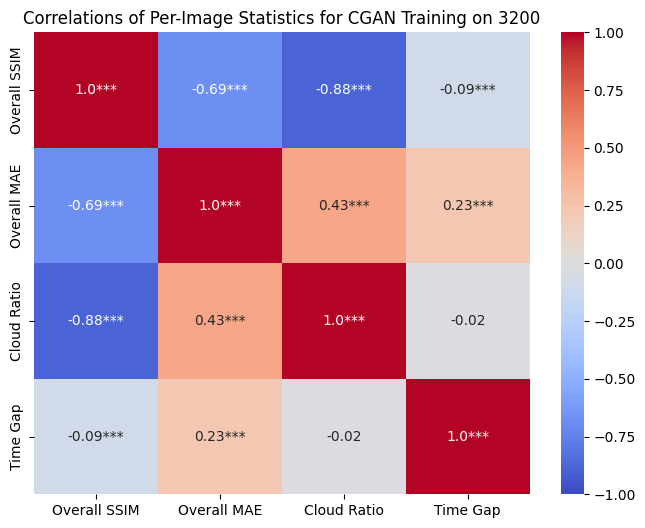

In [26]:
# get a subset of the dataframe to calculate correlations
df = df[['Overall SSIM', 'Overall MAE',
       'Cloud Ratio', 'Time Gap']]

# get correlations and format as a dataframe to use as labels for the heatmap pairgrid
rho = df.corr()
pval = df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
significant_correlations = rho.round(2).astype(str) + p

# create the heatmap of p-values
plt.figure(figsize=(8, 6))
sns.heatmap(rho, annot=significant_correlations, fmt='', cmap="coolwarm", vmin=-1, vmax=1)
plt.title(f'Correlations of Per-Image Statistics for ViT Fine-Tuning on {training_length}')

# save per image correlation heatmap to visualization directory
plt.savefig(save_dir / 'per_image_correlations.png', format='png')

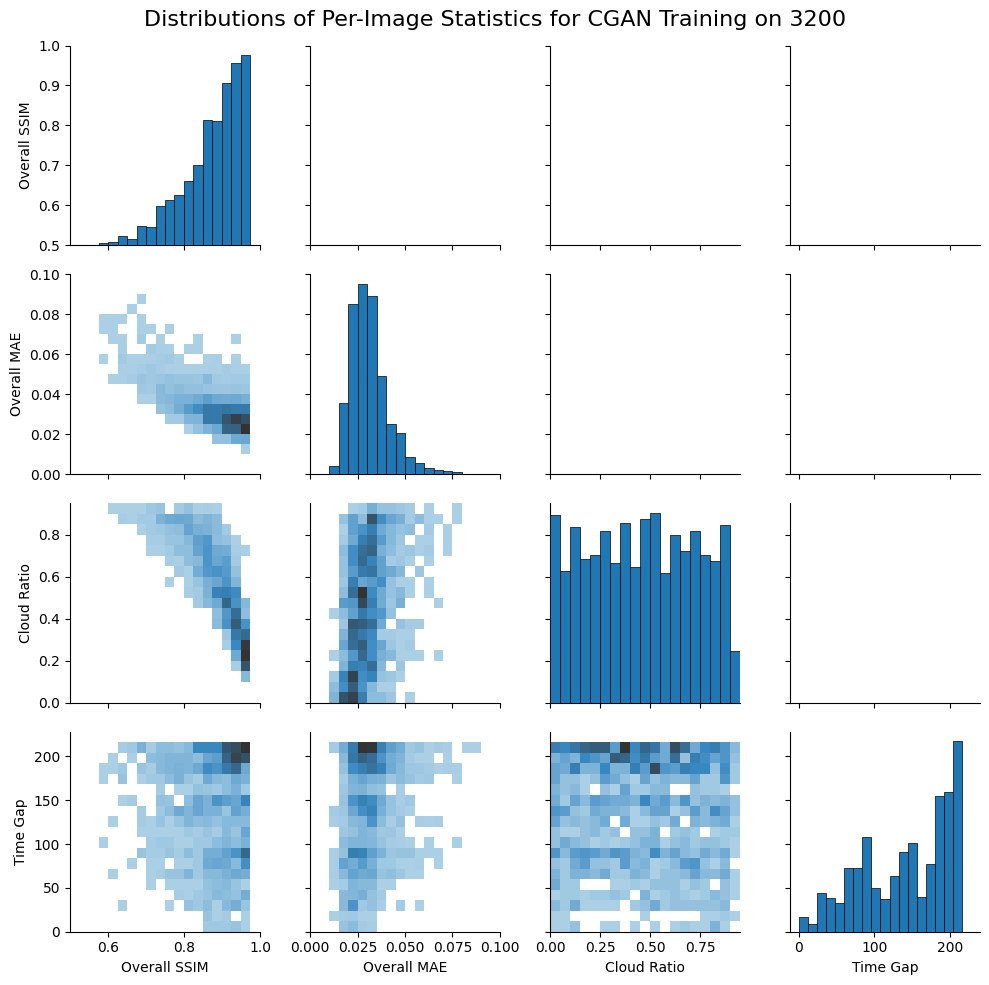

In [27]:
# define custom bin ranges for each column of dataframe
bins = {'Overall SSIM' : [round(i * 0.025, 3) + 0.5 for i in range(20)],
        'Overall MAE' : [round(i * 0.005, 3) for i in range(20)],
        'Cloud Ratio' : [round(i * 0.05, 3) for i in range(20)],
        'Time Gap' : [round(i * 12, 3) for i in range(20)]}

# function to create histograms with custom bins
def myhist(x, **kwargs):
    b = bins[x.name]
    plt.hist(x, bins=b, edgecolor='black', linewidth=0.5, **kwargs)

# function to create 2d histograms with custom bins for each dimension
def mypair(x, y, **kwargs):
    bins_x = bins[x.name]
    bins_y = bins[y.name]
    cmap=sns.color_palette("Blues_d", as_cmap=True)
    plt.hist2d(x, y, bins=[bins_x, bins_y], cmap=cmap, linewidth=0, cmin=1, **kwargs)

# get subset of dataframe
df = df[['Overall SSIM', 'Overall MAE', 'Cloud Ratio', 'Time Gap']]

# define pairgrid and map functions to diagonal and lower cells of pairgrid
g = sns.PairGrid(df, diag_sharey=False)
g.map_diag(myhist)
g.map_lower(mypair)

# set custom limits for SSIM and MAE cells
g.axes[0,0].set_xlim(0.5,1)
g.axes[0,0].set_ylim(0.5,1)
g.axes[1,1].set_xlim(0,0.1)
g.axes[1,1].set_ylim(0,0.1)

# add title and save to visualization directory
plt.suptitle(f'Distributions of Per-Image Statistics for ViT Fine-Tuning on {training_length}', fontsize=16)
plt.tight_layout()
plt.savefig(save_dir / 'per_image_pairgrid.png', format='png')
